# Yelp Reviews: BERT: Classification of 1 & 2 vs 5 Stars on Reviews

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
import os
import random
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from subprocess import call
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
my_dpi = 96

     |████████████████████████████████| 4.2 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 62.7 MB/s 
     |████████████████████████████████| 596 kB 73.1 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
print('Torch version: {}'.format(torch.__version__))
print('pyTorch VERSION:', torch.__version__)
print('\n')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(['nvidia-smi', '--format=csv,' '--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free'])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Sat May 21 16:35:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|            

In [ ]:
# Set seed
seed_value = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Preprocessing




In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,wonderful place get lunch staff friendly effic...
3,5.0,dedicated loving memory gary feldman greatest ...
5,5.0,love place everything menu delicious like tuna...
7,5.0,truely hidden gem place greatest buffalo chick...
9,5.0,seriously great fresh fantastic food spot pric...


In [ ]:
# Examine word count since BERT only takes up to 512
df['review_wordCount'] = df['cleanReview'].apply(lambda x: len(str(x).split()))
df['review_wordCount'].describe().apply('{0:f}'.format)

count    1541486.000000
mean          51.557839
std           46.882433
min            0.000000
25%           21.000000
50%           37.000000
75%           65.000000
max          531.000000
Name: review_wordCount, dtype: object

In [ ]:
# Drop wordCount variable
df = df[df['review_wordCount'] <= 512]
df = df.drop(['review_wordCount'], axis=1)

In [ ]:
# Recode to binary
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts()

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770738
dtype: int64

In [ ]:
# Filter and sample 1 & 2 star reviews
df1 = df[df.stars_reviews==0]
df1 = df1.sample(n=20000)

# Filter and sample 5 star reviews
df2 = df[df.stars_reviews==1]
df2 = shuffle(df2)
df2 = df2.sample(n=20000)

# Concatenate and shuffle
df = pd.concat([df1, df2])
df = shuffle(df)

del df1, df2

df.shape

(40000, 2)

In [ ]:
# Define data types
df['stars_reviews'] = df['stars_reviews'].astype('int')
df['cleanReview'] = df['cleanReview'].astype(str)

In [ ]:
# Partition data for train, validation and test sets
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=seed_value),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

del df

32000 4000 4000


# Build a dataset class

In [ ]:
# Define tokenizer and label
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
label = {0, 1}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):

        self.labels = [label for label in df['stars_reviews']]
        self.texts = [tokenizer(cleanReview,
                                add_special_tokens=True,
                                padding='max_length', max_length=300,
                                return_tensors='pt',
                                truncation=True) for cleanReview in df['cleanReview']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    # Fetch a batch of labels
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    # Fetch a batch of inputs
    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Define model architecture

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.4):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(dropout)
        self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.drop1 = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 2)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,
                                     return_dict=False)
        output = self.drop(pooled_output)
        output = self.out1(output)
        output = self.relu(output)
        output = self.drop1(output)
        final_layer = self.out(output)

        return final_layer

In [ ]:
destination_folder = '/content/drive/MyDrive/Yelp_Reviews/Models/DL/BERT/ReviewStars/Models'

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/DL/BERT/ReviewStars/40k/

In [ ]:
# Save and Load Functions
def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):

    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list,
                 global_steps_list):

    if save_path == None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_metrics(load_path):

    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

# Train and evaluate using batch_size=8

In [ ]:
# Define training function
def train(model,
          df_train,
          df_val,
          learning_rate,
          num_epochs=3,
          file_path=destination_folder,
          best_valid_loss=float('Inf')):

    # Initialize running values
    total_loss_train = 0.0
    total_loss_val = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # Load data
    train, val = Dataset(df_train), Dataset(df_val)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8,
                                                   shuffle=True, pin_memory=True,
                                                   num_workers=4)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8,
                                                 shuffle=True, pin_memory=True,
                                                 num_workers=4)

    # Assign to cuda
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')

    # Define model criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
    eval_every = len(train_dataloader) // 2

    # Training loop
    model.train()
    for epoch in range(num_epochs):
          for train_input, train_label in tqdm(train_dataloader):
              train_label = train_label.to(device)
              mask = train_input['attention_mask'].to(device)
              input_id = train_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)

            # Update running value
              batch_loss = criterion(output, train_label)
              total_loss_train += batch_loss.item()

              optimizer.zero_grad()
              batch_loss.backward()
              optimizer.step()
              global_step += 1

            # Validation loop
              if global_step % eval_every == 0:
                model.eval()

                with torch.no_grad():
                    for val_input, val_label in val_dataloader:
                        val_label = val_label.to(device)
                        mask = val_input['attention_mask'].to(device)
                        input_id = val_input['input_ids'].squeeze(1).to(device)
                        output = model(input_id, mask)
                        batch_loss = criterion(output, val_label)
                        total_loss_val += batch_loss.item()

                # Evaluation of loss and accuracy
                average_train_loss = total_loss_train / len(train_dataloader)
                average_valid_loss = total_loss_val / len(val_dataloader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # Resetting running values
                total_loss_train = 0.0
                total_loss_val = 0.0
                model.train()

                # Print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step,
                              num_epochs*len(train_dataloader),
                              average_train_loss, average_valid_loss))

                # Save model in checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model_40k_b8.pt', model,
                                    best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics_40k_b8.pt',
                                 train_loss_list, valid_loss_list,
                                 global_steps_list)
    save_metrics(file_path + '/' + 'metrics_40k_b8.pt', train_loss_list,
                 valid_loss_list, global_steps_list)
    print('Training finished!')

In [ ]:
# Define model parameters
model = BertClassifier()
optimizer = optim.Adam(model.parameters(), lr=5e-6)
num_epochs = 3
LR = 5e-6

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Train model
train(model, df_train, df_val, LR, num_epochs)

 50%|████▉     | 1999/4000 [09:18<09:18,  3.59it/s]

Epoch [1/3], Step [2000/12000], Train Loss: 0.1219, Valid Loss: 0.1283


 50%|█████     | 2000/4000 [10:05<8:04:24, 14.53s/it]

Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/model_40k_b8.pt
Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/metrics_40k_b8.pt


100%|█████████▉| 3999/4000 [19:23<00:00,  3.59it/s]

Epoch [1/3], Step [4000/12000], Train Loss: 0.0710, Valid Loss: 0.1232


100%|██████████| 4000/4000 [20:11<00:00,  3.30it/s]


Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/model_40k_b8.pt
Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/metrics_40k_b8.pt


 50%|████▉     | 1999/4000 [09:17<09:18,  3.58it/s]

Epoch [2/3], Step [6000/12000], Train Loss: 0.0477, Valid Loss: 0.1192
Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/model_40k_b8.pt


 50%|█████     | 2000/4000 [10:06<8:14:40, 14.84s/it]

Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/metrics_40k_b8.pt


100%|█████████▉| 3999/4000 [19:24<00:00,  3.58it/s]

Epoch [2/3], Step [8000/12000], Train Loss: 0.0477, Valid Loss: 0.0900
Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/model_40k_b8.pt


100%|██████████| 4000/4000 [20:13<00:00,  3.30it/s]


Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/metrics_40k_b8.pt


 50%|█████     | 2000/4000 [10:04<7:48:57, 14.07s/it]

Epoch [3/3], Step [10000/12000], Train Loss: 0.0299, Valid Loss: 0.0969


100%|██████████| 4000/4000 [20:08<00:00,  3.31it/s]

Epoch [3/3], Step [12000/12000], Train Loss: 0.0292, Valid Loss: 0.1026
Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/metrics_40k_b8.pt
Training finished!


## Examine model metrics

Model loaded from <== /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/metrics_40k_b8.pt


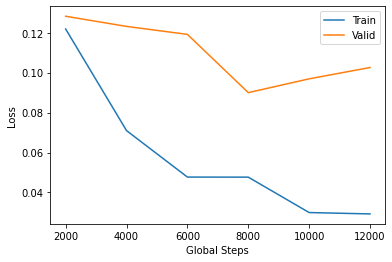

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder
                                                                   + '/metrics_40k_b8.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig('RS_BERT_40k_batch8_globalSteps.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Evaluation Function
def evaluate(model, test_data):
    y_pred = []
    y_true = []

    # Load test set
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

    # Assign to cuda
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')

    # Evaluate model on test set
    if use_cuda:
        model = model.cuda()
    total_acc_test = 0
    model.eval()
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              y_pred.extend(torch.argmax(output, 1).tolist())
              y_true.extend(test_label.tolist())
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    f, (ax) = plt.subplots(1,1)
    f.suptitle('Test Set: Confusion Matrix', fontsize=20)
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='d')
    ax.set_xlabel('Predicted Review Stars', fontsize=17)
    ax.set_ylabel('Actual Review Stars', fontsize=17)
    ax.xaxis.set_ticklabels(['1/2', '5'], fontsize=17)
    ax.yaxis.set_ticklabels(['1/2', '5'], fontsize=17)
    f.savefig('RS_BERT_40k_batch8_testSet_batch1_CF.png',
              dpi=my_dpi*10, bbox_inches='tight')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== /content/drive/MyDrive/Yelp_Reviews/Models/DL/BERT/ReviewStars/Models/model_40k_b8.pt
Test Accuracy:  0.970
Classification Report:
              precision    recall  f1-score   support

           1     0.9846    0.9550    0.9696      2002
           0     0.9563    0.9850    0.9704      1998

    accuracy                         0.9700      4000
   macro avg     0.9704    0.9700    0.9700      4000
weighted avg     0.9704    0.9700    0.9700      4000



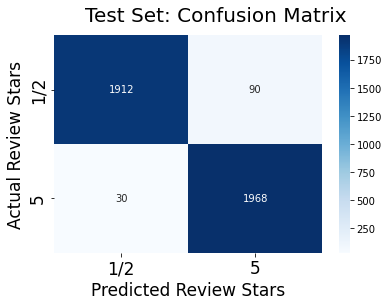

In [ ]:
# Evaluate on test set
best_model = BertClassifier()

load_checkpoint(destination_folder + '/model_40k_b8.pt', best_model)

evaluate(best_model, df_test)

# Train and evaluate using batch_size=1

In [ ]:
# Define training function
def train(model,
          df_train,
          df_val,
          learning_rate,
          num_epochs=3,
          file_path=destination_folder,
          best_valid_loss=float('Inf')):

    # Initialize running values
    total_loss_train = 0.0
    total_loss_val = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # Load data
    train, val = Dataset(df_train), Dataset(df_val)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=1,
                                                   shuffle=True, pin_memory=True,
                                                   num_workers=4)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=1,
                                                 shuffle=True, pin_memory=True,
                                                 num_workers=4)
    # Assign to cuda
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')

    # Define model criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
    eval_every = len(train_dataloader) // 2

    # Training loop
    model.train()
    for epoch in range(num_epochs):
          for train_input, train_label in tqdm(train_dataloader):
              train_label = train_label.to(device)
              mask = train_input['attention_mask'].to(device)
              input_id = train_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)

            # Update running value
              batch_loss = criterion(output, train_label)
              total_loss_train += batch_loss.item()

              optimizer.zero_grad()
              batch_loss.backward()
              optimizer.step()
              global_step += 1

            # Validation loop
              if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    for val_input, val_label in val_dataloader:
                        val_label = val_label.to(device)
                        mask = val_input['attention_mask'].to(device)
                        input_id = val_input['input_ids'].squeeze(1).to(device)
                        output = model(input_id, mask)
                        batch_loss = criterion(output, val_label)
                        total_loss_val += batch_loss.item()

                # Evaluation of loss and accuracy
                average_train_loss = total_loss_train / len(train_dataloader)
                average_valid_loss = total_loss_val / len(val_dataloader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # Resetting running values
                total_loss_train = 0.0
                total_loss_val = 0.0
                model.train()

                # Print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step,
                              num_epochs*len(train_dataloader),
                              average_train_loss, average_valid_loss))

                # Save model in checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model_40k_b1.pt', model,
                                    best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics_40k_b1.pt',
                                 train_loss_list, valid_loss_list,
                                 global_steps_list)
    save_metrics(file_path + '/' + 'metrics_40k_b1.pt', train_loss_list,
                 valid_loss_list, global_steps_list)
    print('Training finished!')

In [ ]:
# Define model parameters
model = BertClassifier()
optimizer = optim.Adam(model.parameters(), lr=5e-6)
num_epochs = 3
LR = 5e-6

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Train model
train(model, df_train, df_val, LR, num_epochs)

 50%|████▉     | 15999/32000 [16:41<16:28, 16.19it/s]

Epoch [1/3], Step [16000/96000], Train Loss: 0.1020, Valid Loss: 0.1101


 50%|█████     | 16002/32000 [17:24<30:04:01,  6.77s/it]

Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/model_40k_b1.pt
Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/metrics_40k_b1.pt


100%|█████████▉| 31998/32000 [34:01<00:00, 16.21it/s]

Epoch [1/3], Step [32000/96000], Train Loss: 0.0637, Valid Loss: 0.0999


100%|██████████| 32000/32000 [34:48<00:00, 15.32it/s]


Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/model_40k_b1.pt
Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/metrics_40k_b1.pt


 50%|█████     | 16002/32000 [17:24<29:25:47,  6.62s/it]

Epoch [2/3], Step [48000/96000], Train Loss: 0.0380, Valid Loss: 0.1001


100%|█████████▉| 31998/32000 [34:03<00:00, 16.20it/s]

Epoch [2/3], Step [64000/96000], Train Loss: 0.0363, Valid Loss: 0.0902


100%|██████████| 32000/32000 [34:48<00:00, 15.32it/s]


Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/model_40k_b1.pt
Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/metrics_40k_b1.pt


 50%|█████     | 16002/32000 [17:22<29:23:29,  6.61s/it]

Epoch [3/3], Step [80000/96000], Train Loss: 0.0186, Valid Loss: 0.1108


100%|██████████| 32000/32000 [34:46<00:00, 15.34it/s]

Epoch [3/3], Step [96000/96000], Train Loss: 0.0185, Valid Loss: 0.1060
Model saved to ==> /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/metrics_40k_b1.pt
Training finished!


## Examine model metrics

Model loaded from <== /content/drive/MyDrive/Yelp_Reviews/DL/BERT/ReviewStars/Models/metrics_40k_b1.pt


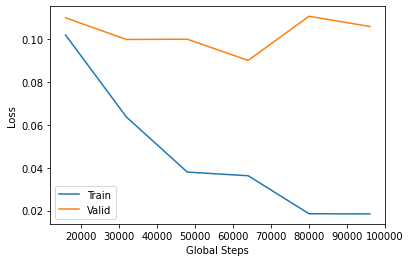

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder
                                                                   + '/metrics_40k_b1.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig('RS_BERT_40k_batch1_globalSteps.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
## Evaluation Function
def evaluate(model, test_data):
    y_pred = []
    y_true = []

    # Load test set
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

    # Assign to cuda
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')

    # Evaluate model on test set
    if use_cuda:
        model = model.cuda()
    total_acc_test = 0
    model.eval()
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              y_pred.extend(torch.argmax(output, 1).tolist())
              y_true.extend(test_label.tolist())
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    f, (ax) = plt.subplots(1,1)
    f.suptitle('Test Set: Confusion Matrix', fontsize=20)
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='d')
    ax.set_xlabel('Predicted Review Stars', fontsize=17)
    ax.set_ylabel('Actual Review Stars', fontsize=17)
    ax.xaxis.set_ticklabels(['1/2', '5'], fontsize=17)
    ax.yaxis.set_ticklabels(['1/2', '5'], fontsize=17)
    f.savefig('RS_BERT_40k_batch1_testSet_batch1_CF.png',
              dpi=my_dpi*10, bbox_inches='tight')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== /content/drive/MyDrive/Yelp_Reviews/Models/DL/BERT/ReviewStars/Models/model_40k_b1.pt
Test Accuracy:  0.977
Classification Report:
              precision    recall  f1-score   support

           1     0.9765    0.9770    0.9768      2002
           0     0.9770    0.9765    0.9767      1998

    accuracy                         0.9768      4000
   macro avg     0.9768    0.9767    0.9767      4000
weighted avg     0.9768    0.9768    0.9767      4000



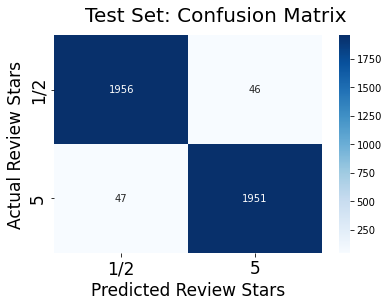

In [ ]:
# Evaluate on test set
best_model = BertClassifier()

load_checkpoint(destination_folder + '/model_40k_b1.pt', best_model)

evaluate(best_model, df_test)